# Big Data Coursework 2

## Part 1: Import Libraries & Initialize SparkSession

In [67]:
# Importing all necessary libraries and functions

import re 
from operator import add
from pyspark.ml import *
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from pyspark.sql import *
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vector
from pyspark.mllib.evaluation import MulticlassMetrics
import pixiedust
from time import time

from pyspark.sql.types import Row
from pyspark.sql import SQLContext
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()


## Part 2: Data Preprocessing

In [2]:
dirPath = 'hdfs://saltdean/data/reviews/Reviews.csv' # Path to the Amazon Reviews dataset

df = spark.read.format("csv").option("header", "true").load(dirPath) # Read the dataset into a dataframe
df.createOrReplaceTempView("reviews") # tag it as reviews so it can be called in SQL

# Text in the review will be used to predict the review score 

SQL1 = "SELECT Score, Text FROM reviews WHERE Score in (1,2,3,4,5)" # Since there was some erroneous data in the score column,
# it was filtered for scores between 1 and 5.
Score_DF = spark.sql(SQL1)
Score_DF = Score_DF.withColumn("Score2",Score_DF.Score.cast("double")).drop("Score").withColumnRenamed("Score2","label")
Score_DF.show()
Score_DF.printSchema()
Score_DF.na.drop()

+--------------------+-----+
|                Text|label|
+--------------------+-----+
|I have bought sev...|  5.0|
|"Product arrived ...|  1.0|
|"This is a confec...|  4.0|
|If you are lookin...|  2.0|
|Great taffy at a ...|  5.0|
|I got a wild hair...|  4.0|
|This saltwater ta...|  5.0|
|This taffy is so ...|  5.0|
|Right now I'm mos...|  5.0|
|This is a very he...|  5.0|
|I don't know if i...|  5.0|
|One of my boys ne...|  5.0|
|My cats have been...|  1.0|
|good flavor! thes...|  4.0|
|The Strawberry Tw...|  5.0|
|My daughter loves...|  5.0|
|I love eating the...|  2.0|
|I am very satisfi...|  5.0|
|Twizzlers, Strawb...|  5.0|
|Candy was deliver...|  5.0|
+--------------------+-----+
only showing top 20 rows

root
 |-- Text: string (nullable = true)
 |-- label: double (nullable = true)



DataFrame[Text: string, label: double]


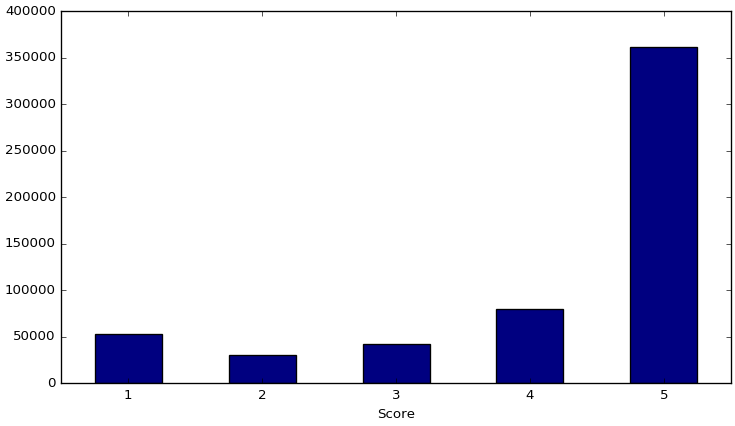

In [3]:
# Finding the distribution of scores in the dataset

SQL2 = "SELECT Score, Count(Score) FROM reviews WHERE Score in (1,2,3,4,5) GROUP BY Score"
Score_Count = spark.sql(SQL2)
Score_Count.show()

# 5 is 1
# 4 is 4.5
# 1 is 7
# 3 is 8
# 2 is 12

# Adding in a weight column, which we were unable to use as no spark ML classifiers support it at this stage.
# This should have helped mitigate the problem of certain classifiers having way more data.

Score_DF = Score_DF.withColumn("weight", F.when(Score_DF.label == 5.0, 1.0).when(Score_DF.label == 4.0, 4.5).when(Score_DF.label == 3.0, 8.0).when(Score_DF.label == 2.0, 12.0).otherwise(7.0))

display(Score_Count)

## Part 3: Train/Test Split

In [4]:
train_set, test_set = Score_DF.randomSplit([0.8,0.2],123) # Split data into training and test

# Vary the size of training sets by random sampling to be ussed alongside the paramgrid

train_set2 = train_set.sample(True, 0.2) # 20% of original training set size 
train_set3 = train_set.sample(True, 0.4) # 40% of original training set size
train_set4 = train_set.sample(True, 0.6) # 60% of original training set size
train_set5 = train_set.sample(True, 0.8) # 80% of original training set size


## Part 4: Pipeline 

In [5]:
# Used so predictions and labels are interpretable
labelIndexer = StringIndexer(inputCol = 'label', outputCol = 'indexedlabel') 

# Split into words/tokens
tokenizer = Tokenizer(inputCol='Text',outputCol='words').setInputCol('Text').setOutputCol('words') 

# Remove Stop words
remover = StopWordsRemover(inputCol = 'words', outputCol = 'filtered', caseSensitive = False) 

# Create field where tokens are grouped into two
ngram2 = NGram(n=2, inputCol="filtered", outputCol="ngrams2") 

# Create field where tokens are grouped into three
ngram3 = NGram(n=3, inputCol="filtered", outputCol="ngrams3") 

# Hash the words into a fixed vector list
hashingTF = HashingTF().setNumFeatures(1000).setInputCol('filtered').setOutputCol('rawFeatures') 

# Hash the 2gram vectors into a fixed vector list
hashingTF2 = HashingTF().setNumFeatures(1000).setInputCol('ngrams2').setOutputCol('rawFeatures2') 

# Hash the 3gram vectors into a fixed vector list
hashingTF3 = HashingTF().setNumFeatures(1000).setInputCol('ngrams3').setOutputCol('rawFeatures3') 

# Assemble the words, 2gram and 3gram vectors into a single vector
Assembler = VectorAssembler(inputCols = ['rawFeatures','rawFeatures2','rawFeatures3'], outputCol = 'features') 

#nb = NaiveBayes().setLabelCol('indexedlabel').setModelType('multinomial').setSmoothing(1) # Not enough parameters to parameter tune
#lr = LogisticRegression(labelCol = 'indexedlabel', maxIter=10, regParam=0.3) # Binary classification, we want 5 classifications
rf = RandomForestClassifier().setLabelCol('indexedlabel').setNumTrees(5) # Chosen classifier, needs parameter tuning and multiple classification allowed

#labelConverter = IndexToString(inputCol = 'prediction', outputCol = 'predictedlabels')

# Pipeline to attach all our functions together
pipeline=Pipeline(stages=[labelIndexer,tokenizer,remover,ngram2,ngram3,hashingTF,hashingTF2,hashingTF3,Assembler,rf])

In [6]:
# Get information for each parameter  using the .explainParams()
print ("LabelIndexer:",labelIndexer.explainParams())
print("\n\n")
print ("Tokenizer:",tokenizer.explainParams())
print("\n\n")
print ("Remover:",remover.explainParams())
print("\n\n")
print ("Ngram2:",ngram2.explainParams())
print("\n\n")
print ("Ngram3:",ngram3.explainParams())
print("\n\n")
print ("HashingTF:",hashingTF.explainParams())
print ("\n\n")
print ("HashingTF2:",hashingTF2.explainParams())
print ("\n\n")
print ("HashingTF3:",hashingTF3.explainParams())
print ("\n\n")
print ("Assembler:",Assembler.explainParams())
print("\n\n")

print ("Pipeline:",pipeline.explainParams())
print("\n\n")

LabelIndexer: handleInvalid: how to handle invalid entries. Options are skip (which will filter out rows with bad values), or error (which will throw an error). More options may be added later. (default: error)
inputCol: input column name. (current: label)
outputCol: output column name. (default: StringIndexer_43d7a6ce622b5edd400d__output, current: indexedlabel)



Tokenizer: inputCol: input column name. (current: Text)
outputCol: output column name. (default: Tokenizer_4ba79f93f3bfcfa2da7f__output, current: words)



Remover: caseSensitive: whether to do a case sensitive comparison over the stop words (default: False, current: False)
inputCol: input column name. (current: words)
outputCol: output column name. (default: StopWordsRemover_491aa339b48ee081d4ec__output, current: filtered)
stopWords: The words to be filtered out (default: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her

## Part 5: Model Selection

In [16]:
# Multiple classifier evaluation 
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction', labelCol="indexedlabel", metricName="accuracy")

# Chosen parameters for parameter tuning from Hashing and Random Forest
paramGrid = ParamGridBuilder()\
.addGrid(hashingTF.numFeatures,[500,1000,1500])\
.addGrid(rf.numTrees, [5,10,15])\
.build()

# Compile all work into a single function for training 80% of training data and evaluate on 20%
TV = TrainValidationSplit()\
.setEstimator(pipeline)\
.setEvaluator(evaluator)\
.setEstimatorParamMaps(paramGrid)\
.setTrainRatio(0.8)

## Part 6: Training

In [17]:
# Training the models on the training data
# Time taken to train is appended to an array for later use in visualisations.

Time = []

startTime = time()
TVModel = TV.fit(train_set)
endTime = time()
print("Time Taken to Train on full training set:", endTime-startTime)

Time.append(['100%', 'Train', endTime-startTime])

startTime = time()
TVModel2 = TV.fit(train_set2)
endTime = time()
print("Time Taken to Train on 20% of training set:", endTime-startTime)

Time.append(['20%', 'Train', endTime-startTime])

startTime = time()
TVModel3 = TV.fit(train_set3)
endTime = time()
print("Time Taken to Train on 40% of training set:", endTime-startTime)

Time.append(['40%', 'Train', endTime-startTime])

startTime = time()
TVModel4 = TV.fit(train_set4)
endTime = time()
print("Time Taken to Train on 60% of training set:", endTime-startTime)

Time.append(['60%', 'Train', endTime-startTime])

startTime = time()
TVModel5 = TV.fit(train_set5)
endTime = time()
print("Time Taken to Train on 80% of training set:", endTime-startTime)

Time.append(['80%', 'Train', endTime-startTime])

Time Taken to Train on full training set: 2844.32155418396
Time Taken to Train on 20% of training set: 816.2523674964905
Time Taken to Train on 40% of training set: 1378.9382939338684
Time Taken to Train on 60% of training set: 1969.3387386798859
Time Taken to Train on 80% of training set: 2738.700607061386


## Part 7: Testing & Evaluation

In [19]:
# Evaluating the models on the testing data
# Time taken to train is appended to an array for later use in visualisations.

Results = []

resulttrain = evaluator.evaluate(TVModel.transform(train_set))
startTime = time()
resulttest = evaluator.evaluate(TVModel.transform(test_set))
print("Accuracy for best fitted model (all training data) =",resulttest)
endTime = time()
print("Time Taken to Test on full training set:", endTime-startTime)

Time.append(['100%', 'Test', endTime-startTime])
Results.append(['100%','Test',resulttest])
Results.append(['100%','Train',resulttrain])

resulttrain = evaluator.evaluate(TVModel2.transform(train_set2))
startTime = time()
resulttest = evaluator.evaluate(TVModel2.transform(test_set))
print("Accuracy for best fitted model (20% training data) =",resulttest)
endTime = time()
print("Time Taken to Test on 20% of training set:", endTime-startTime)

Time.append(['20%', 'Test', endTime-startTime])
Results.append(['20%','Test',resulttest])
Results.append(['20%','Train',resulttrain])


resulttrain = evaluator.evaluate(TVModel3.transform(train_set3))
startTime = time()
resulttest = evaluator.evaluate(TVModel3.transform(test_set))
print("Accuracy for best fitted model (40% training data) =",resulttest)
endTime = time()
print("Time Taken to Test on 40% of training set:", endTime-startTime)

Time.append(['40%', 'Test', endTime-startTime])
Results.append(['40%','Test',resulttest])
Results.append(['40%','Train',resulttrain])

resulttrain = evaluator.evaluate(TVModel4.transform(train_set4))
startTime = time()
resulttest = evaluator.evaluate(TVModel4.transform(test_set))
print("Accuracy for best fitted model (60% training data) =",resulttest)
endTime = time()
print("Time Taken to Test on 60% of training set:", endTime-startTime)

Time.append(['60%', 'Test', endTime-startTime])
Results.append(['60%','Test',resulttest])
Results.append(['60%','Train',resulttrain])

resulttrain = evaluator.evaluate(TVModel5.transform(train_set5))
startTime = time()
resulttest = evaluator.evaluate(TVModel5.transform(test_set))
print("Accuracy for best fitted model (80% training data) =",resulttest)
endTime = time()
print("Time Taken to Test on 80% of training set:", endTime-startTime)

Time.append(['80%', 'Test', endTime-startTime])
Results.append(['80%','Test',resulttest])
Results.append(['80%','Train',resulttrain])

Accuracy for best fitted model (all training data) = 0.6372609500308452
Time Taken to Test on full training set: 46.780184268951416
Accuracy for best fitted model (20% training data) = 0.6372785758350225
Time Taken to Test on 20% of training set: 47.54750633239746
Accuracy for best fitted model (40% training data) = 0.6372873887371111
Time Taken to Test on 40% of training set: 47.275522232055664
Accuracy for best fitted model (60% training data) = 0.6372168855204019
Time Taken to Test on 60% of training set: 48.2775936126709
Accuracy for best fitted model (80% training data) = 0.6372873887371111
Time Taken to Test on 80% of training set: 47.6242413520813


In [62]:
# Extracting Parameters from best model for each training set size

print('20% of Training Data')

bestPipeline = TVModel2.bestModel
stages = bestPipeline.stages

hashingStage = stages[5]
print("numFeatures = ", hashingStage.getNumFeatures)

rfStage = stages[9]
print("numTrees = ", rfStage.getNumTrees)

print('40% of Training Data')

bestPipeline = TVModel3.bestModel
stages = bestPipeline.stages

hashingStage = stages[5]
print("numFeatures = ", hashingStage.getNumFeatures)

rfStage = stages[9]
print("numTrees = ", rfStage.getNumTrees)

print('60% of Training Data')

bestPipeline = TVModel4.bestModel
stages = bestPipeline.stages

hashingStage = stages[5]
print("numFeatures = ", hashingStage.getNumFeatures)

rfStage = stages[9]
print("numTrees = ", rfStage.getNumTrees)

print('80% of Training Data')

bestPipeline = TVModel5.bestModel
stages = bestPipeline.stages

hashingStage = stages[5]
print("numFeatures = ", hashingStage.getNumFeatures)

rfStage = stages[9]
print("numTrees = ", rfStage.getNumTrees)

print('100% of Training Data')

bestPipeline = TVModel.bestModel
stages = bestPipeline.stages

hashingStage = stages[5]
print("numFeatures = ", hashingStage.getNumFeatures)

rfStage = stages[9]
print("numTrees = ", rfStage.getNumTrees)

# 5 is 0
# 4 is 1
# 3 is 3
# 2 is 4
# 1 is 2

20% of Training Data
numFeatures =  <bound method HasNumFeatures.getNumFeatures of HashingTF_4f4798771ec64440e2f0>
numTrees =  5
40% of Training Data
numFeatures =  <bound method HasNumFeatures.getNumFeatures of HashingTF_4f4798771ec64440e2f0>
numTrees =  10
60% of Training Data
numFeatures =  <bound method HasNumFeatures.getNumFeatures of HashingTF_4f4798771ec64440e2f0>
numTrees =  10
80% of Training Data
numFeatures =  <bound method HasNumFeatures.getNumFeatures of HashingTF_4f4798771ec64440e2f0>
numTrees =  10
100% of Training Data
numFeatures =  <bound method HasNumFeatures.getNumFeatures of HashingTF_4f4798771ec64440e2f0>
numTrees =  5


In [26]:
Results # Display the table of results for different training sizes

[['100%', 'Test', 0.6372609500308452],
 ['100%', 'Train', 0.6388306674020959],
 ['20%', 'Test', 0.6372785758350225],
 ['20%', 'Train', 0.6393791102942805],
 ['40%', 'Test', 0.6372873887371111],
 ['40%', 'Train', 0.6383137925912069],
 ['60%', 'Test', 0.6372168855204019],
 ['60%', 'Train', 0.6378146146909389],
 ['80%', 'Test', 0.6372873887371111],
 ['80%', 'Train', 0.6407289198337145]]

In [23]:
Time # Display the table of time for different training sizes

[['100%', 'Train', 2844.32155418396],
 ['20%', 'Train', 816.2523674964905],
 ['40%', 'Train', 1378.9382939338684],
 ['60%', 'Train', 1969.3387386798859],
 ['80%', 'Train', 2738.700607061386],
 ['100%', 'Test', 46.780184268951416],
 ['20%', 'Test', 47.54750633239746],
 ['40%', 'Test', 47.275522232055664],
 ['60%', 'Test', 48.2775936126709],
 ['80%', 'Test', 47.6242413520813]]